<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicamos las técnicas de preprocesamiento que hemos comprobado más efectivas y aplicamos word emmbedding. Al ser el resultado una matriz aplicamos CNN

BN alternatives

https://towardsdatascience.com/an-alternative-to-batch-normalization-2cee9051e8bc

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re
import string
from collections import Counter

nltk.download("popular")
nltk.download('stopwords')
print(tf.__version__)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [ ]:
df = pd.read_csv("gdrive/My Drive/TFG/overviews_final.csv", sep='#',encoding='utf-8', lineterminator='\n')

df['text_array'] = df.overview.str.split(" ")
df['n_words'] = df['text_array'].apply(lambda x: len(x))
df = df.drop(columns=['text_array'])
#df = df[df['n_words']>15]

df.shape

(2043, 10)

In [ ]:
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: eval(x))

In [ ]:
# Normalización

def normalize(x):
  x = x.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      x = x.replace(a, b)

  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','ªº¡¿'))   
  x = x.replace("  ", " ") 
  return x

# Stop_words

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()
stop_words = [normalize(word) for word in stop_words]

def delete_stop_words(x):
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

# Steaming

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)

In [ ]:
df['overview'] = df['overview'].progress_apply(lambda x: normalize(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [normalize(i) for i in x])

df['overview'] = df['overview'].progress_apply(lambda x: delete_stop_words(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [delete_stop_words(i) for i in x])

df['overview'] = df['overview'].progress_apply(lambda x: stem_sentence(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [48]:
# Get Text augmentation

X = df.drop(columns=['like'])
y = df['like']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, stratify=y_train, random_state=10) 

X_test = X_test['overview']
y_test = y_test.values

X_val = X_val['overview']
y_val = y_val.values

X_train_new = X_train['overview'].copy()
y_train_new = y_train.copy()

for i in range(0, len(X_train)):
  new_series_X = pd.Series(X_train.iloc[i]['new_overviews'])
  X_train_new = X_train_new.append(new_series_X, ignore_index=True)

  y_value = y_train.iloc[i]
  new_series_y = pd.Series([y_value, y_value])
  y_train_new = y_train_new.append(new_series_y, ignore_index=True)

y_train_new = y_train_new.values
y_train = y_train_new

In [49]:
# Parameters
num_words = 6000

Como en la practica lo que hace Keras para calcular el embedding es indexar la matriz de embbedding necesitamos asignar un índice a cada palabra y aplicarlo a los textos, vamos a generar este indice en función de las sinopsis del train.

In [50]:
# https://keras.io/api/preprocessing/text/

#tokenizer = Tokenizer(num_words=num_words, oov_token='OOV') # Mark non vocabulary words with index 1
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_new)
print(X_train_new[0]) 

X_train = tokenizer.texts_to_sequences(X_train_new) 
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index for future padding

print(X_train[0]) 
print(vocab_size)

# Max length vector
print(len(max(X_train, key=len)))

print(tokenizer.word_index.items())

malv hechicer damod desafi peligr vortic rob orbe elemental negr servir prepar plan siniestr venganz rein ismir berek guerrer melor bruj aficion reun guerrer luch ejercit criatur espant damod recuper orbe devuelv estabil rein filmaffinity
[330, 2889, 4619, 537, 21, 10840, 122, 4620, 478, 235, 2890, 369, 93, 791, 292, 168, 6577, 6578, 251, 6579, 508, 317, 356, 251, 25, 187, 203, 2785, 4619, 166, 4620, 3565, 2891, 168, 116]
12164
117
dict_items([('vid', 1), ('viv', 2), ('henry', 3), ('decid', 4), ('amig', 5), ('conoc', 6), ('descubr', 7), ('jov', 8), ('anos', 9), ('hombr', 10), ('mund', 11), ('nin', 12), ('guerr', 13), ('hij', 14), ('human', 15), ('lleg', 16), ('pas', 17), ('famili', 18), ('cas', 19), ('encontr', 20), ('peligr', 21), ('padr', 22), ('acab', 23), ('chic', 24), ('luch', 25), ('ayud', 26), ('misteri', 27), ('asesin', 28), ('unic', 29), ('viaj', 30), ('unid', 31), ('busc', 32), ('secret', 33), ('oficial', 34), ('tuerc', 35), ('tom', 36), ('jam', 37), ('histori', 38), ('agent'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


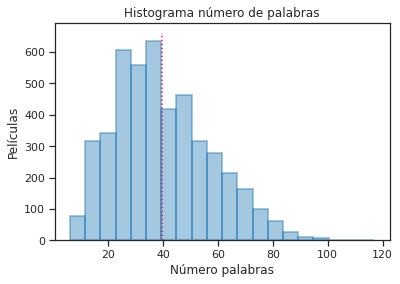

In [51]:
n_words_train = np.array([len(i) for i in X_train])

# seaborn histogram
sns.distplot(n_words_train, hist=True, kde=False, 
             bins=20,
             hist_kws={'edgecolor':'tab:blue', 'linewidth': 2})
# Add labels
plt.title('Histograma número de palabras')
plt.xlabel('Número palabras')
plt.ylabel('Películas')

mean = n_words_train.mean()
plt.vlines(mean, 0, 660, color='crimson', ls=':')

In [52]:
pd.Series(n_words_train).describe()

count    4593.000000
mean       39.673198
std        17.421367
min         6.000000
25%        27.000000
50%        37.000000
75%        51.000000
max       117.000000
dtype: float64

In [53]:
maxlen = 117

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen, truncating='post')
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen, truncating='post')
X_val = pad_sequences(X_val, padding='pre', maxlen=maxlen, truncating='post')

X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,   330,  2889,  4619,   537,    21, 10840,   122,  4620,
         478,   235,  2890,   369,    93,   791,   292,   168,  6577,
        6578,   251,  6579,   508,   317,   356,   251,    25,   187,
         203,  2785,  4619,   166,  4620,  3565,  2891,   168,   116],
      dtype=int32)

# CNN

In [54]:
embedding_dim = 32

In [97]:
inputs = layers.Input(shape=(maxlen,))

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)
x = layers.Dropout(0.35)(x)

# Conv1D + global max pooling
x = layers.Conv1D(32, 5, padding="valid", activation="relu", strides=2)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.35)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

In [98]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 117)]             0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 117, 32)           389248    
_________________________________________________________________
dropout_30 (Dropout)         (None, 117, 32)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 57, 32)            5152      
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_31 (Dropout)         (None, 16)                0  

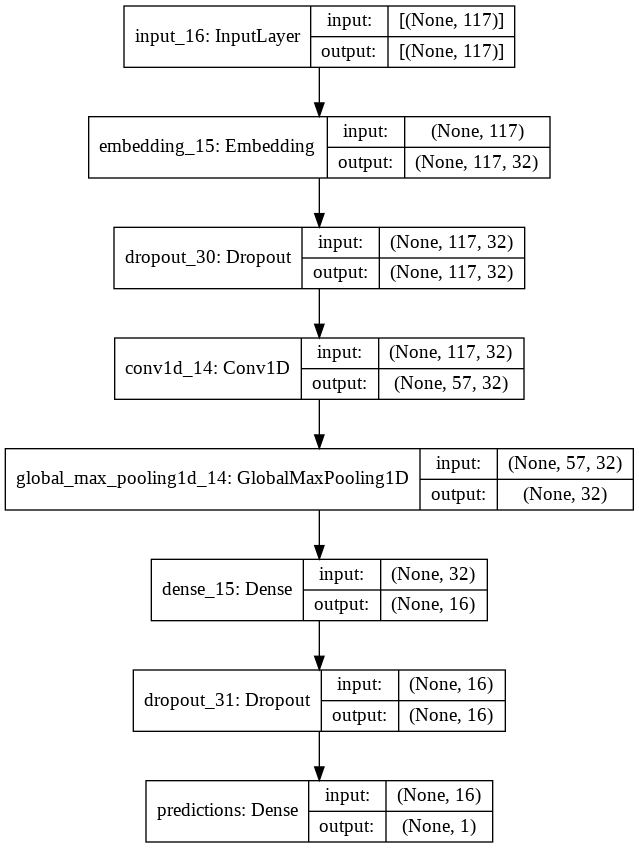

In [99]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [100]:
epochs = 8
batch_size = 8

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size)

Epoch 1/8
575/575 [==============================] - 4s 7ms/step - loss: 0.6932 - accuracy: 0.5200 - val_loss: 0.6895 - val_accuracy: 0.5472
Epoch 2/8
575/575 [==============================] - 4s 6ms/step - loss: 0.6874 - accuracy: 0.5447 - val_loss: 0.6872 - val_accuracy: 0.5472
Epoch 3/8
575/575 [==============================] - 4s 6ms/step - loss: 0.6801 - accuracy: 0.5507 - val_loss: 0.6845 - val_accuracy: 0.5472
Epoch 4/8
575/575 [==============================] - 4s 6ms/step - loss: 0.6726 - accuracy: 0.5694 - val_loss: 0.6770 - val_accuracy: 0.5537
Epoch 5/8
575/575 [==============================] - 4s 6ms/step - loss: 0.6520 - accuracy: 0.6409 - val_loss: 0.6581 - val_accuracy: 0.6840
Epoch 6/8
575/575 [==============================] - 4s 6ms/step - loss: 0.6082 - accuracy: 0.7767 - val_loss: 0.6106 - val_accuracy: 0.7785
Epoch 7/8
575/575 [==============================] - 4s 6ms/step - loss: 0.5236 - accuracy: 0.8728 - val_loss: 0.5357 - val_accuracy: 0.7915
Epoch 8/8
575

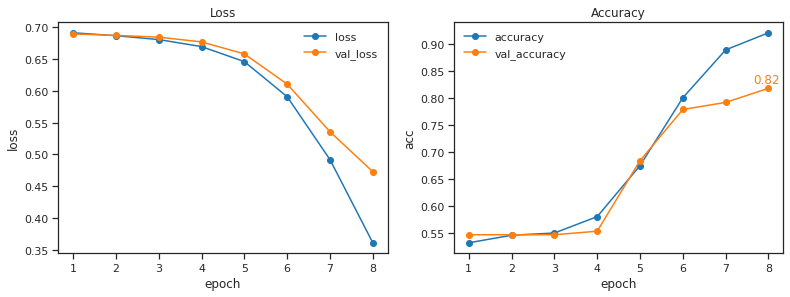

In [101]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)
# label points on the plot only if they are less than 0.43
#for x, y in zip(fit_history['epoch'], fit_history['val_loss']):
#  if y <0.43:
#   ax1.text(x = x - 0.35, # x-coordinate position of data label
#            y = y + 0.02, # y-coordinate position of data label, adjusted to be 150 below the data point
#            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
#            color = 'tab:orange') # set colour of line

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)
for x, y in zip(fit_history['epoch'], fit_history['val_accuracy']):
  if y >0.80:
   ax2.text(x = x - 0.35, # x-coordinate position of data label
            y = y + 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
            color = 'tab:orange') # set colour of line

Con este modelo hemos conseguido reducir la varianza a consta de tener un bias mayor

https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [102]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(4)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(4)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(4)))
print('F1: ' + str(f1_score(y_true, y_pred).round(4)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.7902
Precision: 0.8049
Recall: 0.7097
F1: 0.7543
Conf. Matrix: 
[[96 16]
 [27 66]]


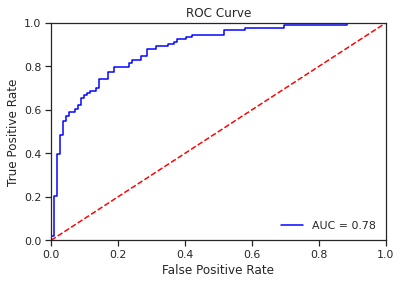

AUC: 0.7834


In [103]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))

# RNN

In [156]:
inputs = layers.Input(shape=(maxlen,))

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# LSTM
x = layers.LSTM(8)(x)
#x = layers.Dropout(0.3)(x)

# We add a vanilla hidden layer:
x = layers.Dense(4, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

In [157]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 117)]             0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 117, 32)           389248    
_________________________________________________________________
dropout_59 (Dropout)         (None, 117, 32)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 8)                 1312      
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_60 (Dropout)         (None, 4)                 0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 5  

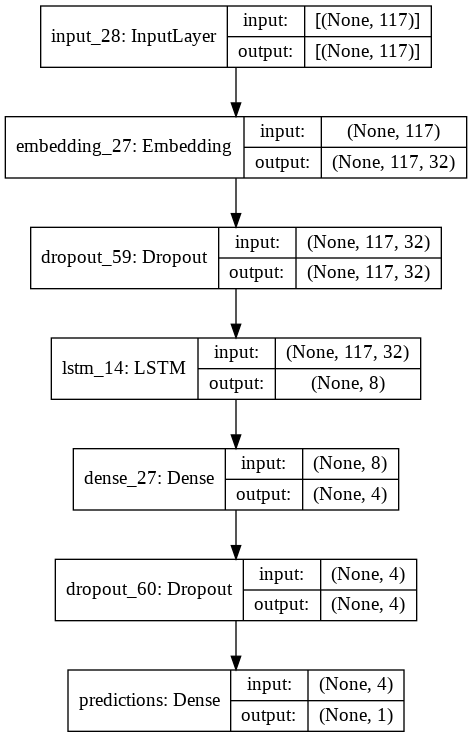

In [158]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [159]:
epochs = 8
batch_size = 8

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size)

Epoch 1/8
575/575 [==============================] - 8s 11ms/step - loss: 0.6909 - accuracy: 0.5615 - val_loss: 0.6881 - val_accuracy: 0.5472
Epoch 2/8
575/575 [==============================] - 6s 11ms/step - loss: 0.6806 - accuracy: 0.5498 - val_loss: 0.6701 - val_accuracy: 0.5668
Epoch 3/8
575/575 [==============================] - 6s 11ms/step - loss: 0.6209 - accuracy: 0.6111 - val_loss: 0.5861 - val_accuracy: 0.7655
Epoch 4/8
575/575 [==============================] - 6s 10ms/step - loss: 0.5221 - accuracy: 0.7774 - val_loss: 0.5502 - val_accuracy: 0.7948
Epoch 5/8
575/575 [==============================] - 6s 11ms/step - loss: 0.4453 - accuracy: 0.8673 - val_loss: 0.5429 - val_accuracy: 0.8046
Epoch 6/8
575/575 [==============================] - 6s 11ms/step - loss: 0.3888 - accuracy: 0.9040 - val_loss: 0.5380 - val_accuracy: 0.7948
Epoch 7/8
575/575 [==============================] - 6s 11ms/step - loss: 0.3680 - accuracy: 0.9022 - val_loss: 0.5370 - val_accuracy: 0.7948
Epoch 

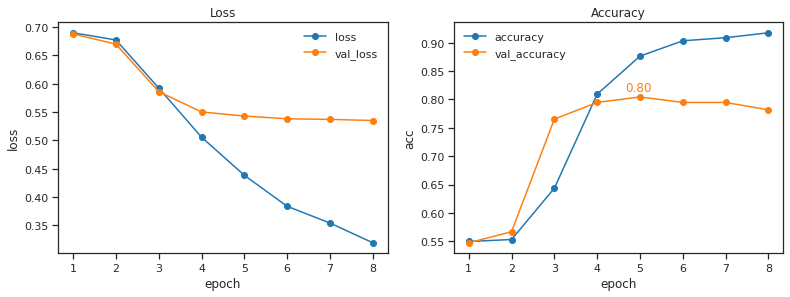

In [162]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)
# label points on the plot only if they are less than 0.43
#for x, y in zip(fit_history['epoch'], fit_history['val_loss']):
#  if y <0.43:
#   ax1.text(x = x - 0.35, # x-coordinate position of data label
#            y = y + 0.02, # y-coordinate position of data label, adjusted to be 150 below the data point
#            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
#            color = 'tab:orange') # set colour of line

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)
for x, y in zip(fit_history['epoch'], fit_history['val_accuracy']):
  if y >0.8:
   ax2.text(x = x - 0.35, # x-coordinate position of data label
            y = y + 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
            color = 'tab:orange') # set colour of line

# CNN + RNN

In [210]:
embedding_dim = 64

In [232]:
inputs = layers.Input(shape=(maxlen,))

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# LSTM
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(16, 5, padding="valid", activation="relu", strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

In [233]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 117)]             0         
_________________________________________________________________
embedding_44 (Embedding)     (None, 117, 64)           778496    
_________________________________________________________________
dropout_98 (Dropout)         (None, 117, 64)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 117, 32)           12416     
_________________________________________________________________
batch_normalization_17 (Batc (None, 117, 32)           128       
_________________________________________________________________
dropout_99 (Dropout)         (None, 117, 32)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 57, 16)            257

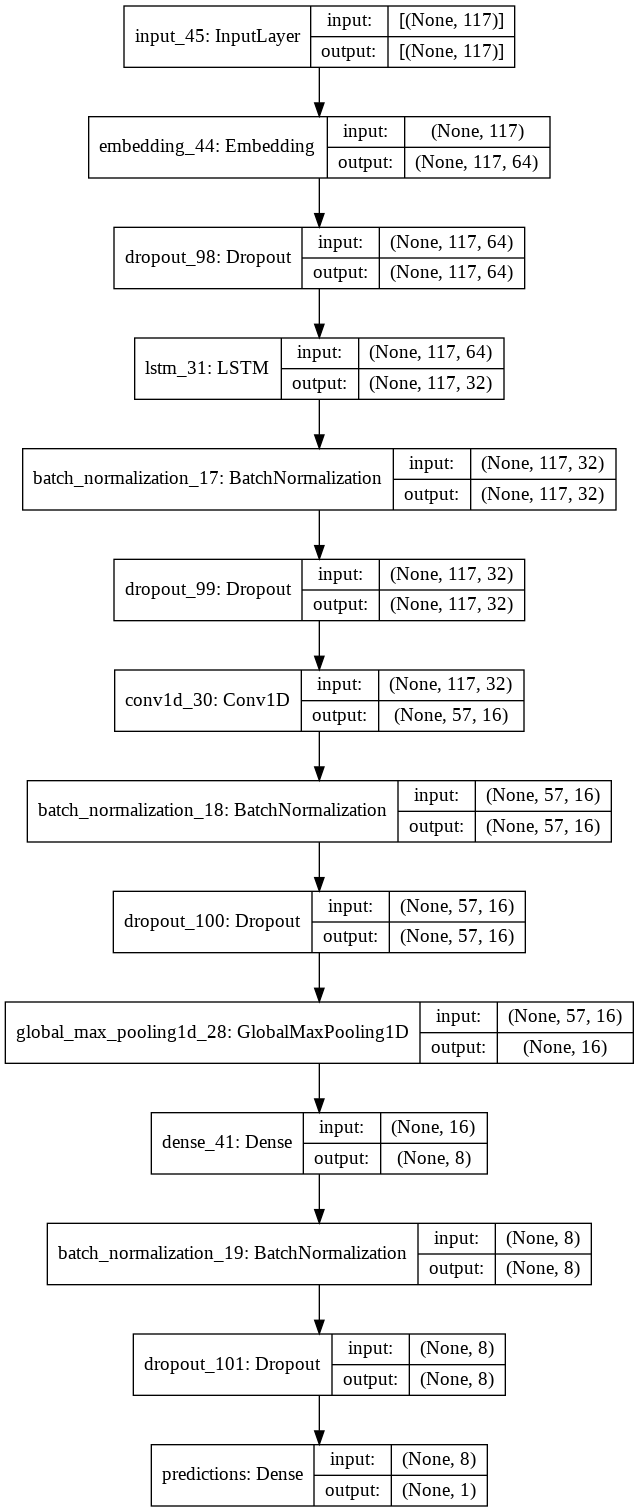

In [234]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [235]:
epochs = 10
batch_size = 8

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size)

Epoch 1/10
575/575 [==============================] - 11s 16ms/step - loss: 0.8882 - accuracy: 0.4883 - val_loss: 0.8715 - val_accuracy: 0.5309
Epoch 2/10
575/575 [==============================] - 9s 16ms/step - loss: 0.8460 - accuracy: 0.4928 - val_loss: 0.8377 - val_accuracy: 0.5733
Epoch 3/10
575/575 [==============================] - 9s 15ms/step - loss: 0.7719 - accuracy: 0.5208 - val_loss: 1.2255 - val_accuracy: 0.5831
Epoch 4/10
575/575 [==============================] - 9s 15ms/step - loss: 0.7637 - accuracy: 0.5208 - val_loss: 0.9731 - val_accuracy: 0.6026
Epoch 5/10
575/575 [==============================] - 9s 15ms/step - loss: 0.7113 - accuracy: 0.5641 - val_loss: 0.6836 - val_accuracy: 0.6450
Epoch 6/10
575/575 [==============================] - 9s 15ms/step - loss: 0.6847 - accuracy: 0.6112 - val_loss: 0.6413 - val_accuracy: 0.6873
Epoch 7/10
575/575 [==============================] - 9s 16ms/step - loss: 0.6214 - accuracy: 0.6633 - val_loss: 0.5964 - val_accuracy: 0.736

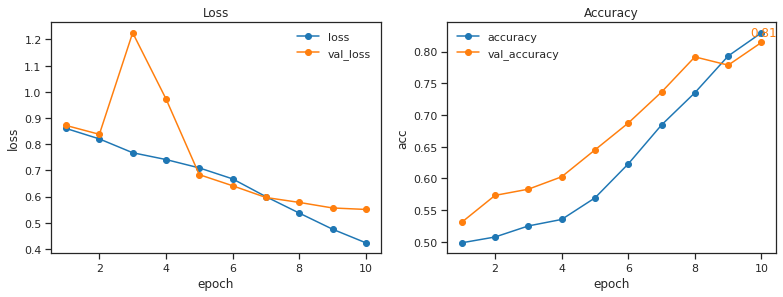

In [236]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)
# label points on the plot only if they are less than 0.43
#for x, y in zip(fit_history['epoch'], fit_history['val_loss']):
#  if y <0.43:
#   ax1.text(x = x - 0.35, # x-coordinate position of data label
#            y = y + 0.02, # y-coordinate position of data label, adjusted to be 150 below the data point
#            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
#            color = 'tab:orange') # set colour of line

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)
for x, y in zip(fit_history['epoch'], fit_history['val_accuracy']):
  if y >0.8:
   ax2.text(x = x - 0.35, # x-coordinate position of data label
            y = y + 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
            color = 'tab:orange') # set colour of line